<a href="https://colab.research.google.com/github/mmrmas/ripeningFruit/blob/sam/week_01_computer_vision_ripeningFruit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💻Week 1 Workbook of unpackAI "DL101 Bootcamp"


## 📕 Learning Objectives of the Week

* Understand the fundamental process of building your own image classification project.

## 🔗 Install & Import Required Code Packages

In [1]:
!pip install -Uqq fastbook

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 186 kB 45.9 MB/s 
     |████████████████████████████████| 46 kB 3.6 MB/s 
     |████████████████████████████████| 1.2 MB 34.2 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 51 kB 274 kB/s 


In [2]:
from fastbook import *
from fastai.vision.widgets import *
from pathlib import Path

Here we mount the google drive to collect images and store the model later

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


get the path to the images 

In [4]:
path  = Path("/content/drive/MyDrive/ColabImages/banana/") 

### Step Three - Data Transformation: Create your **DataLoaders** and utilize **Data Augmentation Methods** to improve your dataset.



/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


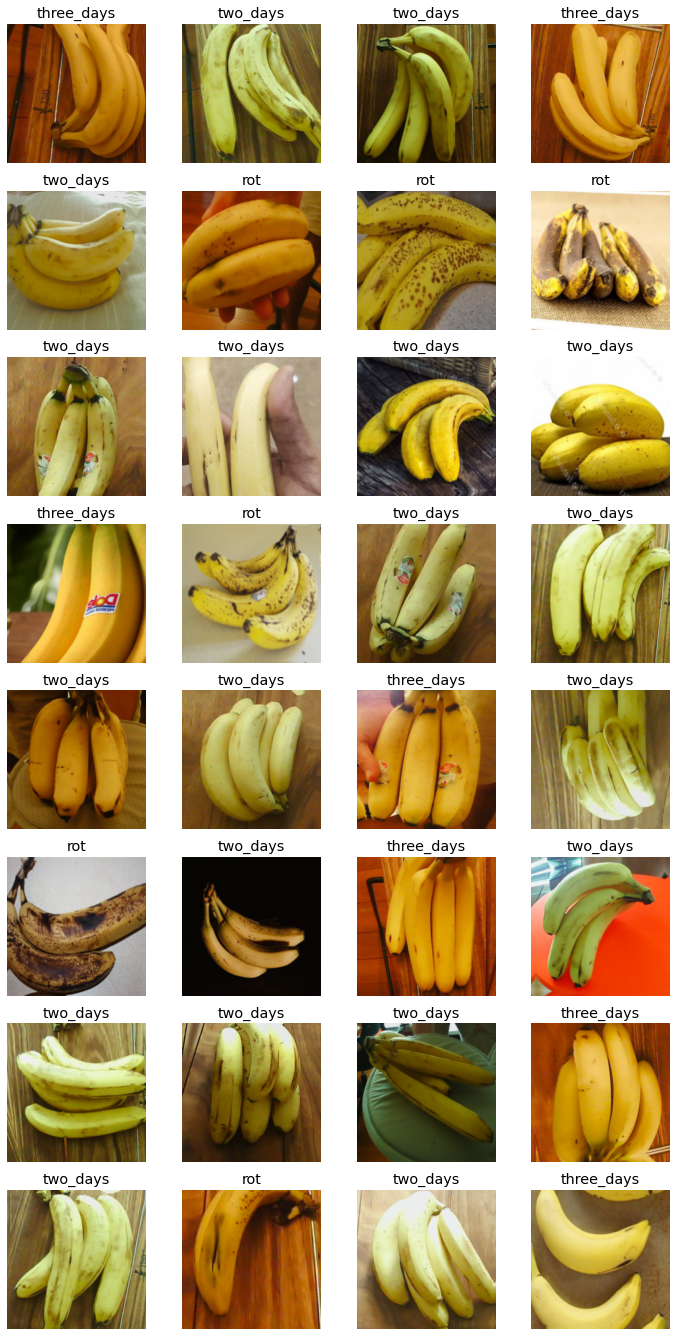

In [5]:
bananas = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.15),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.8),
    #item_tfms=Resize(128, ResizeMethod.Squish),
    #item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'),
    batch_tfms=aug_transforms()
)
# This model can be used to predict how many days before your bananas start to rot with 90% accuricy
# It can be implemented by conumers who want to know the expiry date, or by shops to 
# provide discount on short shelf life banana's

# this model is based on pictures of bananas taken at different time points, stored at 25C
# rotten banana pictures have been supplemented by a DDG search for images
# also supplemented fresh bananas to the 3 days group
# trikcy: often a same white background is used on-line, creates bias
# tricky: keeping or removing borderline data

# optimizing this model:
# given the fluid margin of "days before rot", the model has been improved to put borderline cases in
# a neighbouring category 
# it seems that resizing and pad works best, with the highest accuracy achieved.
# All images have different sizes, and squishing bananas is never a good idea!

dls = bananas.dataloaders(path)
dls.train.show_batch(max_n=32, nrows=8, unique=False)

### Step Three - Train your model.

Train it; we don't need to further clean because the images were manually selected

In [23]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(7)

epoch,train_loss,valid_loss,accuracy,time
0,1.892127,2.486828,0.266667,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.451101,1.447605,0.400000,00:03
1,1.410407,0.721528,0.733333,00:03
2,1.212336,0.388043,0.800000,00:03
3,1.094247,0.282310,0.866667,00:03
4,1.008511,0.249981,0.933333,00:03
5,0.943353,0.249872,0.933333,00:03
6,0.879342,0.252798,0.933333,00:03


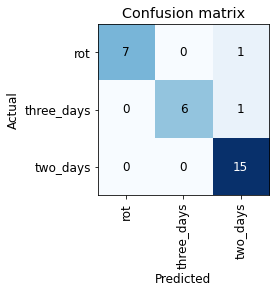

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Save the model

In [13]:
#pip install pyyaml h5py  # Required to save models in HDF5 format
#import os
import torch


# Save the entire model as a pkl ( to re-use in this script) and pt (to use as a standalone off-line).
!mkdir -p drive/MyDrive/saved_model_bananas
learn.export('drive/MyDrive/saved_model_bananas/bananaModel.pkl') 

!mkdir -p drive/MyDrive/saved_model_bananas_torch
#torch.save(learner.model.state_dict(),'drive/MyDrive/saved_model_bananas_torch/bananaModel_state_dict.pt')
torch.save(learner.model,'drive/MyDrive/saved_model_bananas_torch/bananaModel2.pt')  #this one seems to work

### Step Four - Interpret the model and make predictions: Create a notebook app to upload and classify external images.

> Hint: Utilize the *top losses* and *classification marix* methods seen in the coursebook to interpret your model.


In [6]:
#@title Build the functionality of our Notebook App

#need a mounted g-drive and the right modules loaded (fastbook, fastai, etc)

learner = load_learner("drive/MyDrive/saved_model_bananas/bananaModel.pkl")

uploader    = widgets.FileUpload()
output      = widgets.Output()
classify    = widgets.Button(description='Classify')
prediction  = widgets.Label()


def on_click_classify(change):
    img = PILImage.create(uploader.data[-1])
    output.clear_output()
    with output: 
      display(img.to_thumb(254,254))
    pred, pred_idx, probs = learner.predict(img)
    prediction.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'


classify.on_click(on_click_classify)

VBox([widgets.Label('Select your image!'), 
      uploader, classify, output, prediction])

last try to get information from the model to plug into the standalone version. 
I have not obtained the normalization paramters though, but the classifier array (tuple) is a good start

In [14]:
learner.dls.vocab


['rot', 'three_days', 'two_days']